## PyCaret 
PyCaret is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

When importing a `pycaret.regression`, you may encounter models import errors. To fix this, manually install the package with `conda install`

In [20]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import shap

In [21]:
# loading data in RAM-saving manner
data_types = {"event_name_1":"object", "event_type_1":"object", 
              "demand":"int16", "wm_yr_wk":"int16", "wday":"int8", 
              "month":"int8","year":"int16", "snap_CA":"int8", "snap_TX":"int8", "snap_WI":"int8", 
              "sell_price": "float32"}

columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand', 'date', 'wm_yr_wk',
           'wday','month', 'year', 'event_name_1', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI', 
           'sell_price']

sales = pd.read_csv("sales.gzip", compression="gzip", dtype=data_types, parse_dates=["date"], usecols=columns)

In [22]:
# initial preprocessing
sales = sales[(sales["date"] > "2015-01-01") & (sales["date"] < "2015-02-01")]
sales.replace({"event_name_1": np.nan, "event_type_1": np.nan}, "no_event", inplace=True)
sales["sell_price"].replace(np.nan, 0, inplace=True)

# sorting dataset by date and droping the date column
sales.sort_values("date", ascending=True, inplace=True)

numeric = ['wm_yr_wk', 'wday','month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price']

# 1. Setup

The first step while working with PyCaret is setting up the environment. The parameters of the function below are settings to be used during further work inside the environment unless other settings are specified in relevant functions.

Here is a brief explanation of paramaters used in the `setup()` function below:

`data` - full dataset (required parameter); <br>
`target` - name of the target column (required parameter); <br>
`session_id` - equivalent to ‘random_state’ in scikit-learn (optional); <br>
`log_experiment` - whether to log the parameters and metrics to ML flow server (optional); <br>
`experiment_name` - just a name of experiment for ML flow server (optional); <br>
`normalize` - whether to normalize numeric features (we can also set the method of norm) (optional); <br>
`fold` - number of folds to be used in cross validation; <br>
`numeric features` - list of features which pycaret should consider numeric. By defalut, pycaret can distinguish numeric, categorical and ordinal features. But we can help by setting parameters like this (optional); <br>
`ordinal features` - list of features which pycaret should consider ordinal (optional); <br>
`data_split_shuffle` - prevents or allows rows shuffeling for train test split (optional); <br>
`fold_strategy` - choice of cross val. strategy.

Please notice, that we specified `item_id` as ordinal feature, although it is not. The fact is that, by default this feature will be treated by PyCaret as categorical. Thus, to preprocess this column PyCaret will use OneHotEncoding. We want to prevent this and use LabelEncoding instead. That's why we say PyCaret to treat this feature as ordinal one.

Also, we set `data_split_shuffle=False`. Since we deal with timeseries data we should make sure to perform the train test split in a right way.

In [23]:
# initiating regression environment
reg01 = setup(data = sales, target = 'demand', session_id=123,
              log_experiment = True, experiment_name = 'sales_1_exp', normalize=True, fold=3, 
              numeric_features=numeric, ordinal_features={"item_id": list(sales["item_id"].unique())}, 
              data_split_shuffle = False, fold_strategy="timeseries", silent=True)

,Description,Value
0,session_id,123
1,Target,demand
2,Original Data,"(914700, 17)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,7
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(640289, 45)"


Note, that in a few moments after calling `setup()` function, it will display dataframe with automaticaly inferred data types. To proceed, you need to press "enter". If you don't agree with assigned data types you should type "quit" and press enter to stop the `setup()`. You can also prevent data types autoinferring by specifying all or some of variable types in relevant `setup()` parameters (`ordinal_features`, `numeric_features`, `categorical_features`) jut like we did.

If you are sure that PyCaret will assign data types correctly, you can set  `silent=True ` to prevent prompting the user data type confirmation.

# 2. Comparing 

PyCaret allows to create different baseline models and see their metrics in one line code using `compare()` function. 

Here is a short info about parameters we used for it.

With default parameters, this function builds all 25 available models, prints their evaluating metrics and returns a model with the highest `R2` score.
To save some time, we can set `include` parameter to a list of estimators that PyCaret should use for comparing. It's a good choice when you want to use a specific algorithm or a few of them. On the other hand, we can use `exculude` parameter to use all available estimators except those specified in the parameter.

If we want our model to return top 2 models (insted of 1) we should mention it in `n_select` parameter. You can also specify `sort` parameter to choose main metric for comparing.

Thus, `top2` variable will store a list of 2 best baselines (with highest `MAE` score).

In [24]:
top2 = compare_models(include = ["lightgbm", "dt"], n_select=2, sort="MAE")
score_df = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,1.1089,8.7692,2.9579,0.2426,0.6333,0.9116,1.0700
lightgbm,Light Gradient Boosting Machine,1.2458,7.1863,2.6727,0.3845,0.6366,0.5887,1.6167


Plase note, that the score dataframe shown above is not returned by the `compare()` function. If you want to return and store this dataframe, you should use `pull()` function right after calling `compare()`. The same applies to any other PyCaret functions displaying but not returning dataframes after being called. 

# 3.Create_model()

`create_model()` function is just another way to create baselines. However, in this case, only one baseline model can be made by calling the function. 

We have already compared 2 baselines, and it seems that vanilla `Light Gradient Boosting Machine` deals better with our data. Let's create two baselines one more time and save them apart. 

In [25]:
lgbm = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.3025,8.7453,2.9573,0.3542,0.6428,0.5941
1,1.2461,6.7186,2.5920,0.3998,0.6391,0.5865
2,1.1889,6.0949,2.4688,0.3995,0.6279,0.5856
Mean,1.2458,7.1863,2.6727,0.3845,0.6366,0.5887
SD,0.0464,1.1315,0.2074,0.0214,0.0063,0.0038


In [26]:
dt = create_model("dt")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1098,9.9559,3.1553,0.2648,0.6309,0.8734
1,1.1066,8.0443,2.8362,0.2814,0.6332,0.9173
2,1.1103,8.3075,2.8823,0.1815,0.6357,0.9441
Mean,1.1089,8.7692,2.9579,0.2426,0.6333,0.9116
SD,0.0017,0.8460,0.1408,0.0437,0.0020,0.0291


# 4. Tuning

PyCaret allows to tune hyperparameters of created models. To do that, we have to specify any trained model object (not only baseline) as a parameter inside `tune_model()` function. 

With other default parameters this function will iterate over it's predefined hyperparameters grid in order to optimize R2 score (each iteration will be performed on N folds specified as a parameter inside this function, otherwise number of folds from the `setup()` function will be used). 

To save time, we set `n_iter=2`. Also, since we are interested in "MAE" score of our model, we ask PyCaret to optimize this metric, instead of default "R2".

In [27]:
lgbm_autotuned = tune_model(lgbm, n_iter=2, optimize="MAE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.4303,11.2302,3.3511,0.1707,0.6839,0.5065
1,1.3570,8.6701,2.9445,0.2255,0.6733,0.4955
2,1.2881,7.3865,2.7178,0.2722,0.6608,0.4748
Mean,1.3585,9.0956,3.0045,0.2228,0.6727,0.4923
SD,0.0580,1.5977,0.2620,0.0415,0.0094,0.0131


`tune_model()` function can be used with our custom grid of hyperparameters. 

In [28]:
grid_params = {'num_leaves': np.arange(10,200,10),
               'max_depth': [int(x) for x in np.linspace(5, 50, num = 10)],
               'learning_rate': np.arange(0.05,0.5,0.05)}

lgbm_tuned = tune_model(lgbm, custom_grid=grid_params, n_iter=2, optimize="MAE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.2110,7.8290,2.7980,0.4218,0.6072,0.6361
1,1.1713,6.1384,2.4776,0.4517,0.6066,0.6312
2,1.1092,5.2967,2.3015,0.4781,0.5937,0.6220
Mean,1.1639,6.4214,2.5257,0.4505,0.6025,0.6298
SD,0.0419,1.0530,0.2056,0.0230,0.0062,0.0058


# 5. Ensembles

We can also easily create different types of model ensambles with PyCaret `ensemble_model()` function. 

## 5.1. Bagging

For example, we can perform bagging with our decision tree baseline. Bagging means building a set of different learners on bootstraped dataset. The final decison is to be made by voting where each learner has equal voting right. And since, each model was trained on different parts of dataset, their votes (decisions) will not be the same. Making the number of such learners bigger helps to obtain more correct final decision. That's why, applying bagging to Decision Tree is almost the same as creating Random Forest.

In [29]:
bagged_dt = ensemble_model(dt, n_estimators=2, optimize="MAE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0841,8.4022,2.8987,0.3795,0.6051,0.7987
1,1.0873,7.0470,2.6546,0.3705,0.6054,0.8349
2,1.0749,6.9149,2.6296,0.3187,0.6067,0.8496
Mean,1.0821,7.4547,2.7276,0.3562,0.6058,0.8277
SD,0.0053,0.6721,0.1214,0.0268,0.0007,0.0214


## 5.2. Boosting

Another type of ensembling is "boosting", i.e. creating certain number of weak learners, where each following learner aims to minimize the errors of the previous one (e.g. adaboost). 

In [30]:
boosted_dt = ensemble_model(dt, method = 'Boosting',  n_estimators=2, optimize="MAE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1757,10.8142,3.2885,0.2014,0.6597,0.9030
1,1.1802,8.7957,2.9657,0.2143,0.6641,0.9547
2,1.1698,8.6293,2.9376,0.1498,0.6591,0.9788
Mean,1.1752,9.4131,3.0639,0.1885,0.6610,0.9455
SD,0.0042,0.9931,0.1592,0.0279,0.0022,0.0316


## 5.3 Blending

Blending is a simple voting of different models. Unlike bagging, here each model is trained on the same datasets and then votes for the final decision. Thus, there is no sence to blend the same algorithms, since all of them will produce same predictions.

In [31]:
blender = blend_models(estimator_list=[dt, lgbm], optimize="MAE")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1081,7.1772,2.6790,0.4700,0.5686,0.6344
1,1.0680,5.1531,2.2700,0.5397,0.5708,0.6466
2,1.0508,5.0666,2.2509,0.5008,0.5704,0.6617
Mean,1.0757,5.7989,2.4000,0.5035,0.5699,0.6475
SD,0.0240,0.9752,0.1975,0.0285,0.0010,0.0112


# 6.Plots

So, after all experiments we discovered that auto tuned lightgbm has the best MAPE score. 
Now, we can build take a closer  look at this model with `plot_model()` function.

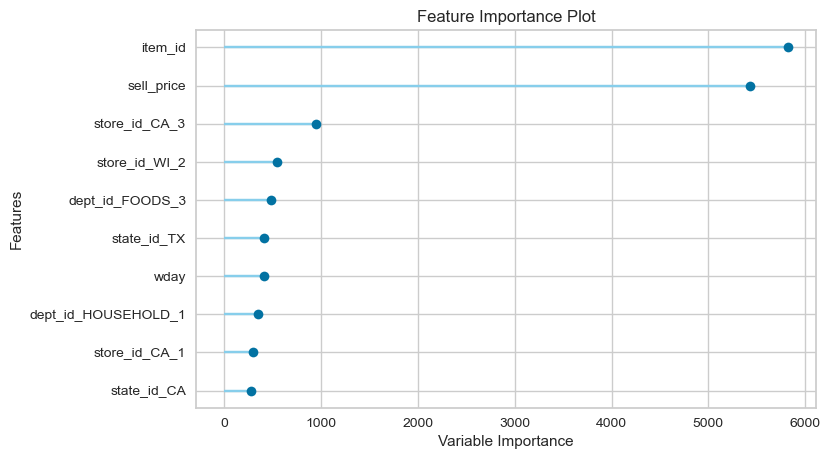

In [32]:
plot_model(lgbm_autotuned, plot="feature")

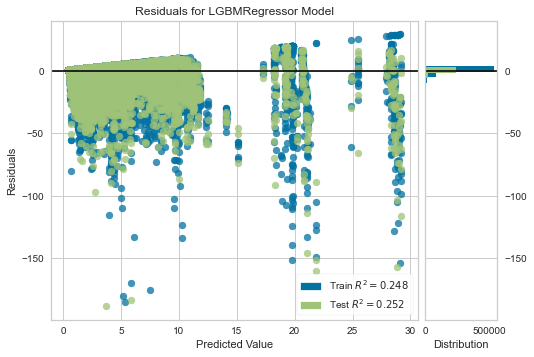

In [33]:
plot_model(lgbm_autotuned)

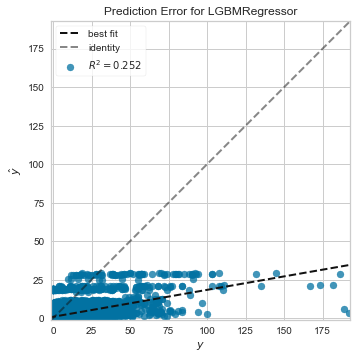

In [34]:
plot_model(lgbm_autotuned, plot = 'error')

# 7. Model Inerpretation

`interpret_model()` function uses SHAP values to help us identify how different values of our features effect the predictions. For example, on this plot we see, that low sale price makes model to predict larger demand.

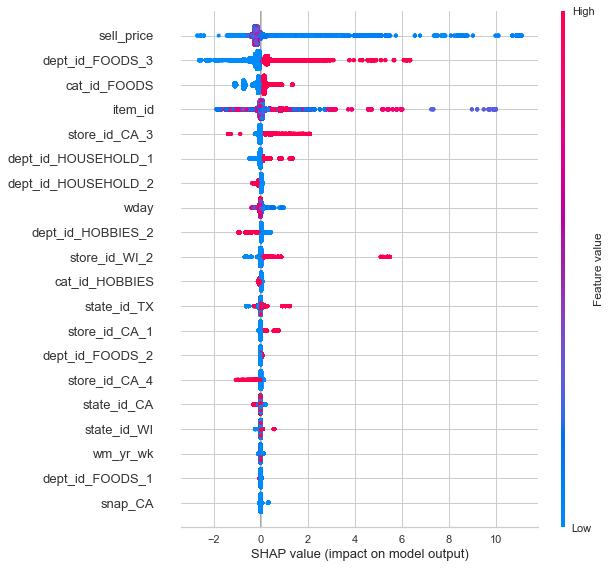

In [19]:
interpret_model(lgbm_autotuned)

# 8. AutoML 

`automl()` function iterates over internal environmental variable containing all models created and chooses the best one with respect to specified metric.

In [35]:
best = automl(optimize = 'MAE')
best

VotingRegressor(estimators=[('dt',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=123,
                                                   splitter='best')),
                            ('li

# 9. Predictions

Now, we can make predictions on the test data. This function returns dataframe with predictions (`Label` column) and metrics of the model on test dataset.

In [36]:
pred_holdouts = predict_model(lgbm)
pred_holdouts.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.2304,6.9869,2.6433,0.4097,0.6243,0.5786


,item_id,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,...,date_weekday_1,date_weekday_2,date_weekday_3,date_weekday_4,date_weekday_5,date_weekday_6,date_is_month_end_0,date_is_month_start_0,demand,Label
0,1038.0,1.286538,1.000002,0.0,0.0,-0.866027,-0.866027,-0.953464,-0.131334,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0.402150
1,9.0,1.286538,1.500002,0.0,0.0,-0.866027,-0.866027,-0.953464,1.588557,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0.400771
2,11.0,1.286538,1.500002,0.0,0.0,-0.866027,-0.866027,-0.953464,-0.988460,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5,3.562166
3,10.0,1.286538,1.500002,0.0,0.0,-0.866027,-0.866027,-0.953464,-0.413283,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0.825241
4,8.0,1.286538,1.500002,0.0,0.0,-0.866027,-0.866027,-0.953464,1.024658,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0.640738


In [37]:
def plot(df, predict_df):
    
    train, new = train_test_split(df, test_size=0.3, train_size=0.7, shuffle=False)
    train = train \
        .loc[(train['store_id'] == 'CA_3') 
             & (train['item_id'].isin(['HOUSEHOLD_1_383', 'HOUSEHOLD_1_366', 'HOUSEHOLD_1_349'])),
             ['date', 'item_id','demand']]

    predict_df.drop(predict_df.tail(1).index,inplace=True)
    new["demand"] = predict_df["Label"].values
    new = new \
        .loc[(new['store_id'] == 'CA_3') & 
             (new['item_id'].isin(['HOUSEHOLD_1_383', 'HOUSEHOLD_1_366', 'HOUSEHOLD_1_349'])), 
             ['date', 'item_id','demand']]
    train["Type"] = "historical"
    new["Type"] = "predicted"
    res = pd.concat([train,new])
    
    chart = alt.Chart(res).mark_line().encode(
        x=alt.X('date:T', title='Date'),
        y=alt.Y('demand:Q', title='Demand'),
        color=alt.Color('item_id', title='Item ID'),
        strokeDash='Type:N'
    ).properties(
        width=700
    )
    
    return chart

In [38]:
import altair as alt
import altair_viewer
from sklearn.model_selection import train_test_split
chart = plot(sales, pred_holdouts)
altair_viewer.display(chart, inline=True)